In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set dataset path
dataset_path = '/kaggle/input/animals-detection-images-dataset'

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_path, 'train'),
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(os.path.join(dataset_path, 'test'),
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical')

# Create a DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=1,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator))

# Store additional information in the model
model.class_names = list(train_generator.class_indices.keys())
model.training_history = history.history
model.architecture = model.to_json()
model.training_parameters = {
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 1
}

# Save the model
model.save('animal_detection_model.h5')

class_indices = train_generator.class_indices
animal_list = list(class_indices.keys())
print(animal_list)

# Make predictions on the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

# Compute the metrics
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

Found 22566 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.
706/706 [==============================] - 1033s 1s/step - loss: 1.6519 - accuracy: 0.5638 - val_loss: 0.9970 - val_accuracy: 0.7085
['Bear', 'Brown bear', 'Bull', 'Butterfly', 'Camel', 'Canary', 'Caterpillar', 'Cattle', 'Centipede', 'Cheetah', 'Chicken', 'Crab', 'Crocodile', 'Deer', 'Duck', 'Eagle', 'Elephant', 'Fish', 'Fox', 'Frog', 'Giraffe', 'Goat', 'Goldfish', 'Goose', 'Hamster', 'Harbor seal', 'Hedgehog', 'Hippopotamus', 'Horse', 'Jaguar', 'Jellyfish', 'Kangaroo', 'Koala', 'Ladybug', 'Leopard', 'Lion', 'Lizard', 'Lynx', 'Magpie', 'Monkey', 'Moths and butterflies', 'Mouse', 'Mule', 'Ostrich', 'Otter', 'Owl', 'Panda', 'Parrot', 'Penguin', 'Pig', 'Polar bear', 'Rabbit', 'Raccoon', 'Raven', 'Red panda', 'Rhinoceros', 'Scorpion', 'Sea lion', 'Sea turtle', 'Seahorse', 'Shark', 'Sheep', 'Shrimp', 'Snail', 'Snake', 'Sparrow', 'Spider', 'Squid', 'Squirrel', 'Starfish', 'Swan', 'Tick', 'Tiger', 'Tortoise

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
# Make predictions on example images
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model('animal_detection_model.h5')

# Define the class names
class_names = list(train_generator.class_indices.keys())

# Load and preprocess the test images
img1 = image.load_img('/kaggle/input/animals-detection-images-dataset/test/Bear/0df78ee76bafd3a9.jpg', target_size=(224, 224))
img2 = image.load_img('/kaggle/input/animals-detection-images-dataset/test/Crocodile/0138fb77f3a3f70d.jpg', target_size=(224, 224))
img3 = image.load_img('/kaggle/input/animals-detection-images-dataset/test/Deer/0285b398989179c8.jpg', target_size=(224, 224))
img4 = image.load_img('/kaggle/input/animals-detection-images-dataset/test/Giraffe/02fbdccb15dfbec8.jpg', target_size=(224, 224))
img5 = image.load_img('/kaggle/input/animals-detection-images-dataset/test/Elephant/028f8db193a85ecf.jpg', target_size=(224, 224))

img1 = image.img_to_array(img1)
img2 = image.img_to_array(img2)
img3 = image.img_to_array(img3)
img4 = image.img_to_array(img4)
img5 = image.img_to_array(img5)

img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)
img3 = np.expand_dims(img3, axis=0)
img4 = np.expand_dims(img4, axis=0)
img5 = np.expand_dims(img5, axis=0)

img1 = img1 / 255.
img2 = img2 / 255.
img3 = img3 / 255.
img4 = img4 / 255.
img5 = img5 / 255.

# Make predictions on the test images
pred1 = model.predict(img1)
pred2 = model.predict(img2)
pred3 = model.predict(img3)
pred4 = model.predict(img4)
pred5 = model.predict(img5)

# Print the predicted class names
print('Image 1:', class_names[np.argmax(pred1)])
print('Image 2:', class_names[np.argmax(pred2)])
print('Image 3:', class_names[np.argmax(pred3)])
print('Image 4:', class_names[np.argmax(pred4)])
print('Image 5:', class_names[np.argmax(pred5)])

1/1 [==============================] - 0s 34ms/step
Image 1: Brown bear
Image 2: Crocodile
Image 3: Deer
Image 4: Deer
Image 5: Elephant


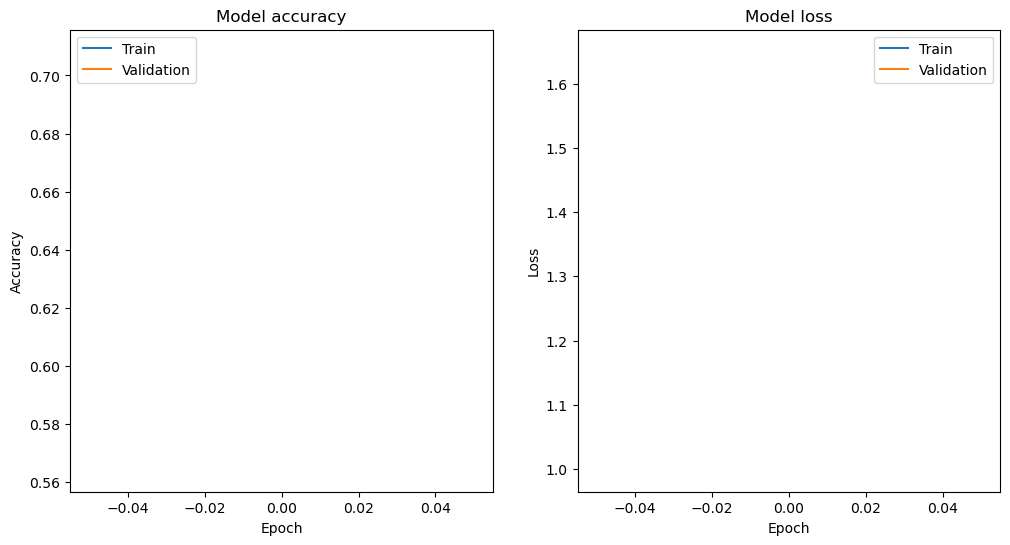

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Load the saved model
model = tf.keras.models.load_model('animal_detection_model.h5')

# Define the class names for the model
train_dataset_path = '/kaggle/input/animals-detection-images-dataset/train'
class_names = sorted(os.listdir(train_dataset_path))

# Plot the model's architecture
plot_model(model, to_file='model.png', show_shapes=True)

# Print the number of trainable and non-trainable parameters
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print('Total params:', trainable_params + non_trainable_params)
print('Trainable params:', trainable_params)
print('Non-trainable params:', non_trainable_params)

Total params: 8169104
Trainable params: 1131600
Non-trainable params: 7037504
